In [10]:
# Define a class for dataset
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Define model

#### Finetuning from a pretrained model

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#### An Instance segmentation model for PennFudan Dataset

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

#### Helper Functions

In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() Method (optional)

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

#### Putting Everything together

In [32]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [48]:
device =torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


In [49]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:56  lr: 0.000090  loss: 5.6060 (5.6060)  loss_classifier: 0.9663 (0.9663)  loss_box_reg: 0.2200 (0.2200)  loss_mask: 4.4142 (4.4142)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.9412  data: 0.0209  max mem: 3654
Epoch: [0]  [10/60]  eta: 0:00:36  lr: 0.000936  loss: 1.9986 (2.6633)  loss_classifier: 0.5701 (0.5598)  loss_box_reg: 0.2457 (0.2606)  loss_mask: 1.0664 (1.8170)  loss_objectness: 0.0234 (0.0213)  loss_rpn_box_reg: 0.0029 (0.0046)  time: 0.7301  data: 0.0269  max mem: 3701
Epoch: [0]  [20/60]  eta: 0:00:28  lr: 0.001783  loss: 1.0342 (1.7794)  loss_classifier: 0.2467 (0.3924)  loss_box_reg: 0.2494 (0.2710)  loss_mask: 0.5536 (1.0894)  loss_objectness: 0.0199 (0.0205)  loss_rpn_box_reg: 0.0048 (0.0062)  time: 0.7075  data: 0.0292  max mem: 3705
Epoch: [0]  [30/60]  eta: 0:00:21  lr: 0.002629  loss: 0.5973 (1.3879)  loss_classifier: 0.1041 (0.2946)  loss_box_reg: 0.2447 (0.2626)  loss_mask: 0.2285 (0.8075)  loss_ob

#### Saving Models

In [50]:
torch.save(model.state_dict(), "model.pth")
print("Saved Pytorch Model Sate to model.pth")

Saved Pytorch Model Sate to model.pth


In [51]:
model.load_state_dict(torch.load("model.pth"))
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

#### Check predictions

In [60]:
# pick one image from the test set
img, _ = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [61]:
prediction

[{'boxes': tensor([[144.5799,  26.4014, 272.6163, 323.6429],
          [287.6265,  53.0976, 413.6924, 324.1851]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9899, 0.9855], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

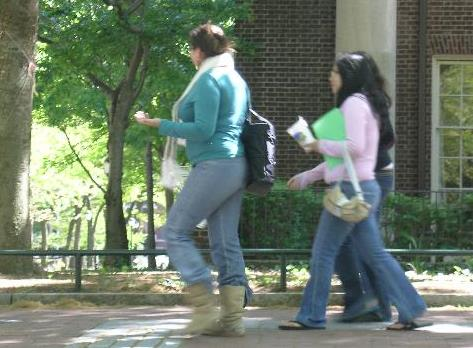

In [62]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

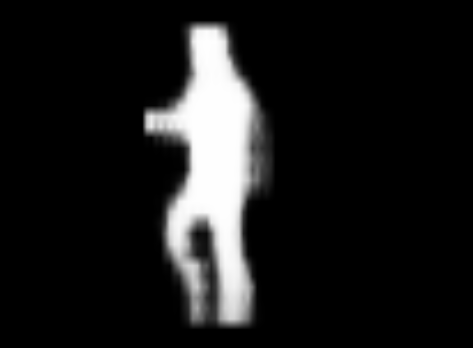

In [63]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())